# Binary classification into amorphous and crystal-like atomic environments - accuracy separated for the 4 categories (CRN, Paracrystalline, Polycrystalline and Diamond)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
from steinhardt import get_steinhardt_params

## Data pre-processing

### Get dataset with atomic coordinates and turn it into a dataset with Stenhard OPs

In [4]:
df=pd.read_pickle('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/df_npt_anneal_293K_ptm-labels_-1.pckl.gzip', compression='gzip')

### Keep labels to 1 for all crystal-like environments

In [5]:
# Create an array with the labels

label_arrays=[]
num_rows = df.shape[0]
for i in range(0, num_rows):
    labels_structure_i=(df['PTM'][i]) #this is a vector with one label for each atom in the structure
    label_arrays.append(labels_structure_i) #append the label vector for each structure to the label_arrays list

labels=np.hstack((label_arrays)) # stack the vectors 

In [23]:
labels_category_list=[]
num_rows = df.shape[0]
dict={'CRN':0, 'Paracrystalline':1, 'Polycrystalline':2, 'Diamond':3}
for i in range(0, num_rows):
    Category_i=(df['Category'][i]) # number of atoms in the structure
    category_label=dict[Category_i]
    n_atoms_i=(df['nb_atoms'][i]) # number of atoms in the structure
    label_category_i = np.repeat(category_label, n_atoms_i) #this is a vector with nb_atoms_i entries all equal to the number of atoms in the structure
    labels_category_list.append(label_category_i) #append the label vector for each structure to the label_struct_size list

labels_category_stacked=np.hstack((labels_category_list)) # vector of size labels to be used in evaluation of the model for each size

In [ ]:
# Generate steinhardt parameters and stack them in a numpy array
num_rows = df.shape[0]
arrays=[]
stein=np.empty(shape=(0, 30))
for i in range(0, num_rows):
    stein_params_structure_i=get_steinhardt_params(df['ase_atoms'][i], cutoff_radius=2.85, numb_neighbours=16, q_l_values = np.arange(3,13,1), w_l_values=np.arange(4,14,2))
    arrays.append(stein_params_structure_i)

result=np.vstack((arrays))

In [12]:
# Get steinhard parameters from csv file
steinhard_params = np.genfromtxt('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/steinhard_param_storage.csv', delimiter=',')[1:]


### Split the dataset with Steinhardt OPs into a training and test set

In [24]:
(X_train,X_test,Y_train, Y_test, Y_train_category, Y_test_category)=train_test_split(steinhard_params, labels, labels_category_stacked, test_size=0.2, random_state=42)


In [25]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
scaled_x_train = torch.FloatTensor(scaler.transform(X_train))
scaled_x_test = torch.FloatTensor(scaler.transform(X_test))

## Model set-up

In [26]:
X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
X_test = torch.tensor(scaled_x_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_train_category = torch.tensor(Y_train_category, dtype=torch.float32)
Y_test_category= torch.tensor(Y_test_category, dtype=torch.float32)


train_data = TensorDataset(X_train, Y_train, Y_train_category)
test_data = TensorDataset(X_test, Y_test, Y_test_category)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)



/tmp/ipykernel_2052936/2946649874.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
/tmp/ipykernel_2052936/2946649874.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(scaled_x_test, dtype=torch.float32)


In [27]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(30, 24)  # input features: 30, hidden: 16
        self.fc2 = nn.Linear(24, 12)   # hidden: 16, output hidden: 8
        self.fc3 = nn.Linear(12, 1)    # hidden: 8, output: 1
        self.sigmoid = nn.Sigmoid()   # Sigmoid activation for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Activation function after first layer
        x = torch.relu(self.fc2(x))   # Activation function after second layer
        x = self.fc3(x)               # Final layer output
        return self.sigmoid(x) 


In [28]:
input_size = X_train.shape[1]
model = BinaryClassifier()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [29]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, labels, structure_types in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        labels = torch.unsqueeze(labels, 1)  # Add an extra dimension to the labels
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.0298
Epoch [2/10], Loss: 0.0250
Epoch [3/10], Loss: 0.0240
Epoch [4/10], Loss: 0.0234
Epoch [5/10], Loss: 0.0230
Epoch [6/10], Loss: 0.0228
Epoch [7/10], Loss: 0.0226
Epoch [8/10], Loss: 0.0224
Epoch [9/10], Loss: 0.0222
Epoch [10/10], Loss: 0.0221


## Confusion matrix

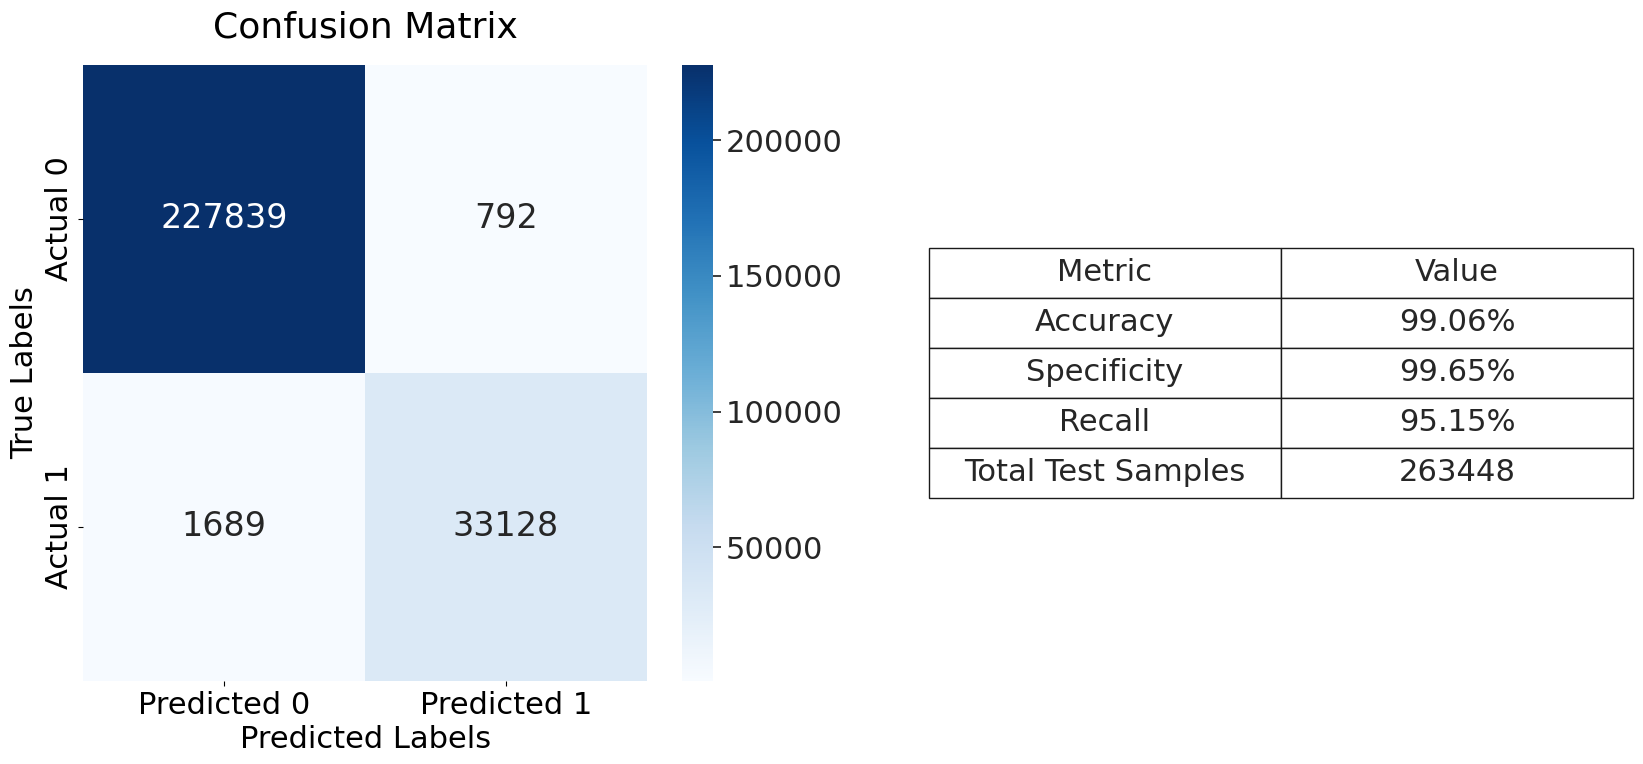

Accuracy: 99.06%
Recall: 95.15%
Specificity: 99.65359028303249
Total test samples: 263448
Correct predictions: 260967
predicted: [tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])]
list_of_ones: 0


In [ ]:
import seaborn as sns

# Evaluation mode (disable gradients for testing)
model.eval()

# Initialize counts for confusion matrix
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

# Track correct predictions
correct = 0
total = 0
list_of_ones=0

with torch.no_grad():  # No need to calculate gradients during testing
    for data, labels, structure_types in test_loader:
        outputs = model(data)
        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        total += labels.size(0)
        predicted = predicted.view(-1)  # Flatten predicted (N, 1) -> (N,)
        labels = labels.view(-1)        # Flatten labels (1, N) -> (N,)
        correct+=(predicted==labels).sum().item()
        TP += ((predicted == 1) & (labels == 1)).sum().item()
        TN += ((predicted == 0) & (labels == 0)).sum().item()
        FP += ((predicted == 1) & (labels == 0)).sum().item()
        FN += ((predicted == 0) & (labels == 1)).sum().item()

# Create confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Create a table with the metrics
metrics_data = {
    'Metric': ['Accuracy', 'Specificity', 'Recall', 'Total Test Samples'],
    'Value': [f'{100 * correct / total:.2f}%', f'{100 * TN / (TN + FP):.2f}%', f'{100 * TP / (TP + FN):.2f}%', total]
}

metrics_df = pd.DataFrame(metrics_data)

# Plot the table next to the confusion matrix
plt.figure(figsize=(20, 8))
ax = plt.subplot(121)
sns.set(font_scale=2.0)  # Adjust the font scale for the numbers in the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=ax)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Confusion Matrix', fontsize=26, pad=20)
plt.xlabel('Predicted Labels', fontsize=22)
plt.ylabel('True Labels', fontsize=22)

ax2 = plt.subplot(122)
ax2.axis('off')
tbl = ax2.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(22)
tbl.scale(1, 3)


plt.savefig('confusion_matrix_all_crystal.png')
plt.show()
print(f'Accuracy: {100 * correct / total:.2f}%')
print(f'Recall: {100 * TP / (TP + FN):.2f}%')
print('Specificity:', 100 * TN / (TN + FP))
print(f'Total test samples: {total}')
print(f'Correct predictions: {correct}')
print(f'predicted: {[predicted]}')
print(f'list_of_ones: {list_of_ones}')



## 4 subplots - confusion matrices per structure type

/u/vld/sjoh5417/miniconda3/envs/project-2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


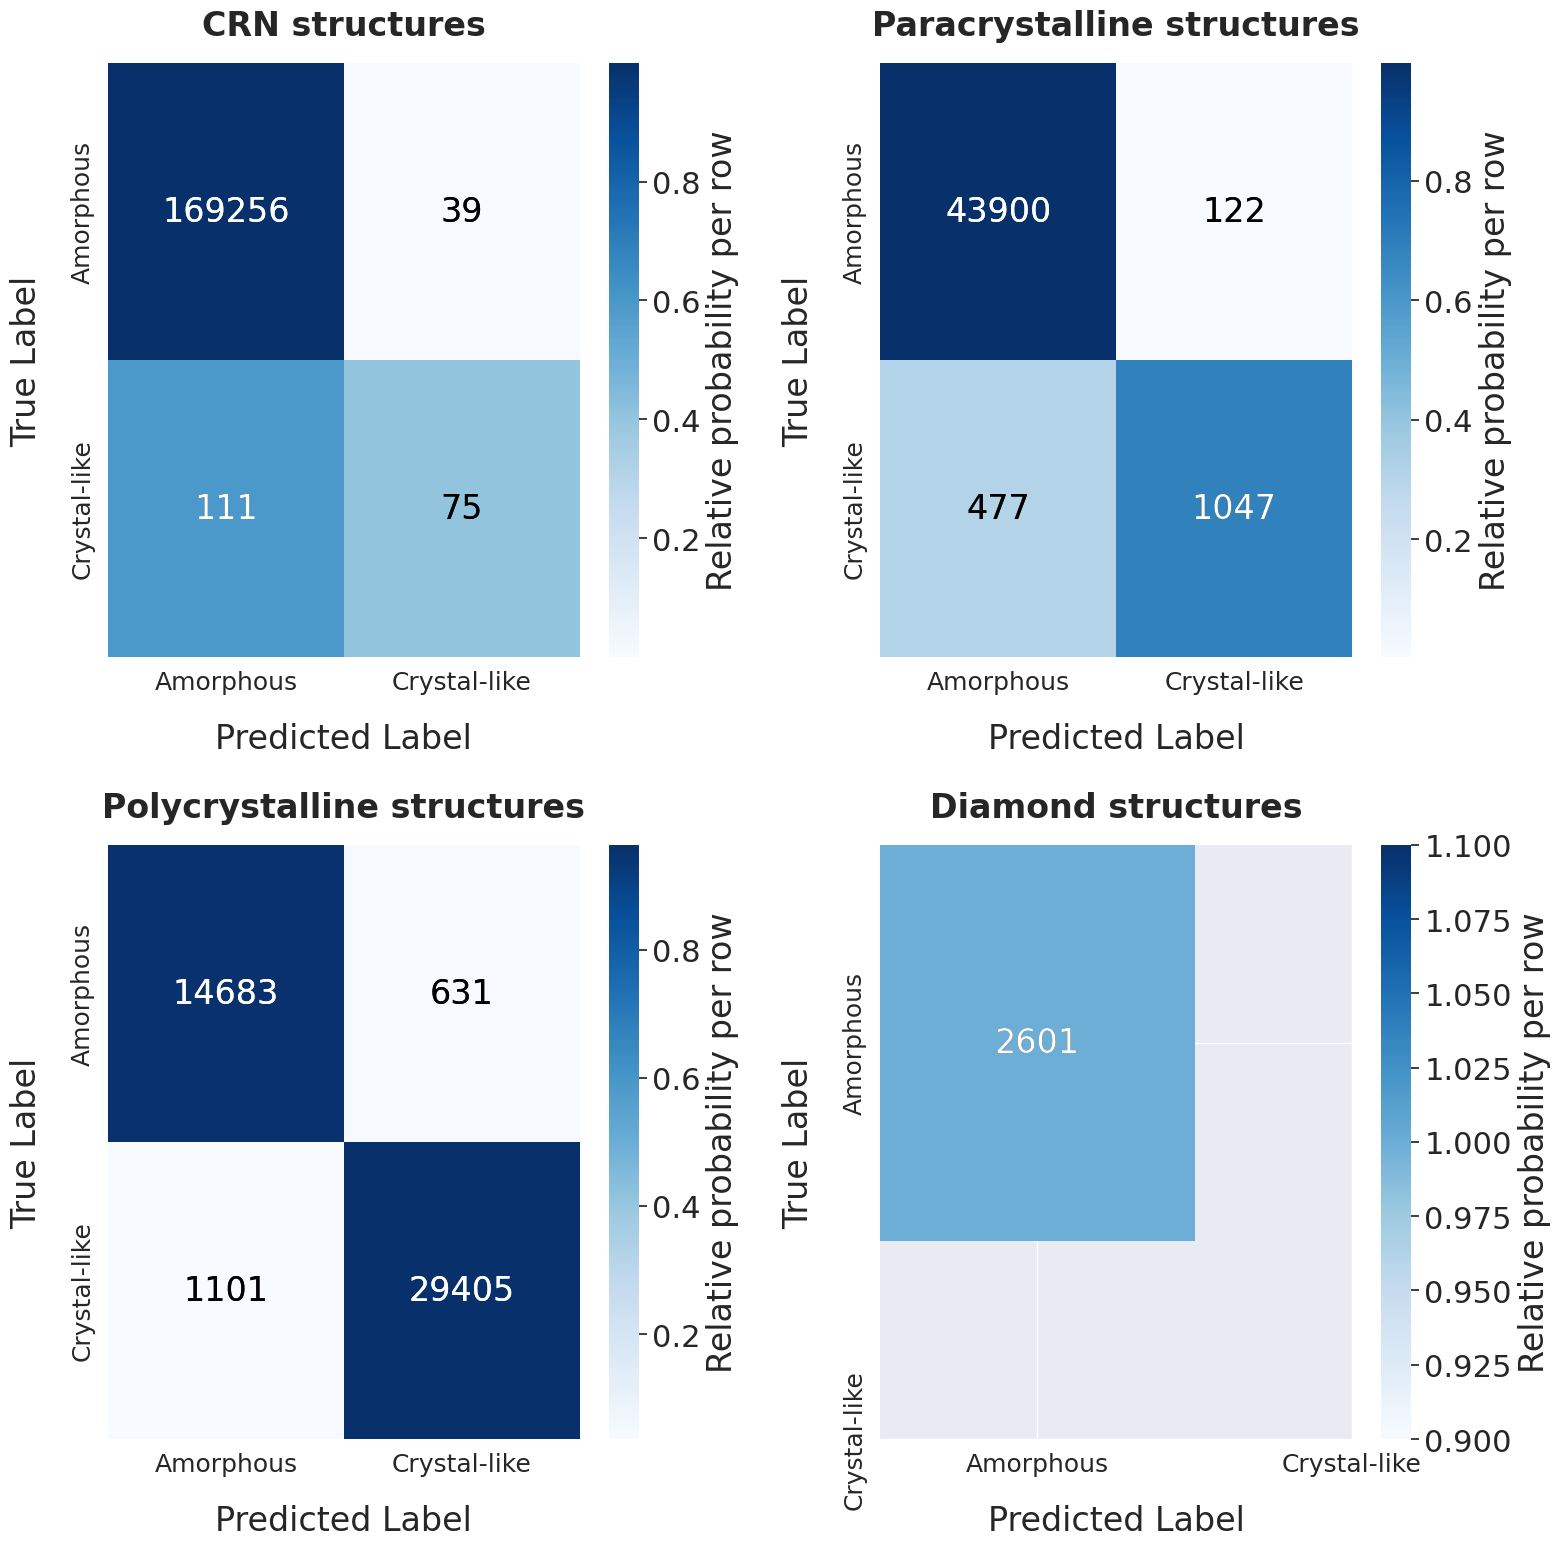

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    true_labels = []
    category_true_labels = []
    y_pred = []


    with torch.no_grad():  # No need to calculate gradients during testing
        for data, labels, structure_types in test_loader:
            outputs = model(data)
            predicted = (outputs > 0.5).float()# Convert probabilities to binary predictions (0 or 1)
            true_labels.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            category_true_labels.extend(structure_types.numpy())

    categories=set(category_true_labels)
    
    category_dict = {0: [0,0], 1: [0,1], 2: [1,0], 3: [1,1]}
    categories_dict = {0: 'CRN', 1: 'Paracrystalline', 2: 'Polycrystalline', 3: 'Diamond'}

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for category in categories:
        indices=[i for i, x in enumerate(category_true_labels) if x == category]
        true_labels_i=[true_labels[i] for i in indices]
        y_pred_i=[y_pred[i] for i in indices]

        #Create a confusion matrix for the specific category
        cm = confusion_matrix(true_labels_i, y_pred_i)

        cm_normalised=cm/cm.sum(axis=1, keepdims=True)

        # plt.figure(figsize=(10, 8))
        axes_index=category_dict[category]
        ax_i=axes[axes_index[0], axes_index[1]]

        sns.heatmap(cm, annot=True, ax=ax_i, cmap='Blues', fmt=".0f", cbar=False, xticklabels=['Amorphous', 'Crystal-like'], yticklabels=['Amorphous', 'Crystal-like'])
        ax=sns.heatmap(cm_normalised, annot=False,  cmap='Blues', cbar=True, ax=ax_i, xticklabels=['Amorphous', 'Crystal-like'], yticklabels=['Amorphous', 'Crystal-like'],
                    cbar_kws={"label":"Relative probability per row"})
        
        ax_i.tick_params(axis='x', labelsize=18, rotation=0)
        ax_i.tick_params(axis='y', labelsize=18)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                # Set text color to white if the background is dark (intensity > 0.5)
                color = "white" if cm_normalised[i, j] > 0.5 else "black"
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:.0f}", ha="center", va="center", color=color)
        
        
        ax_i.set_title(f"{categories_dict[category]} structures", pad=20, fontweight='bold' )
        ax_i.set_xlabel('Predicted Label', labelpad=20)
        ax_i.set_ylabel('True Label', labelpad=20)
        plt.savefig(f'confusion_matrix_crystal_like_classifier_per_category_exp_9.png')

    plt.tight_layout()  # Prevents overlap between plots
    plt.show()
    

plot_confusion_matrix(model, test_loader)